<a href="https://colab.research.google.com/github/ounospanas/AIDL_A_02/blob/main/notebooks_solutions/AIDL_A02_network_optimization_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load dataset
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


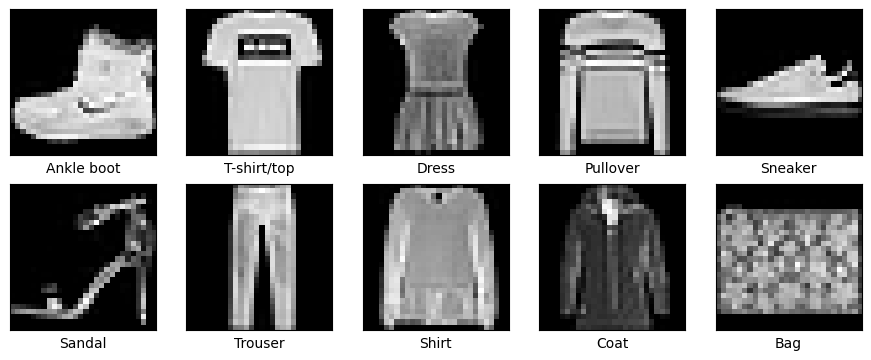

In [3]:
#visualize some data
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
selected = [0,1,3,5,6,8,16,18,19,23]
plt.figure(figsize=(11, 11))
for i, s in enumerate(selected):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    #img = plt.imread(x_train[s])
    plt.imshow(x_train[s], cmap='gray')
    plt.xlabel(classes[y_train[s]],)

In [4]:
# normalize data
x_train = x_train.reshape(x_train.shape[0],-1)/255
x_test = x_test.reshape(x_test.shape[0],-1)/255

# Binary Classification

In [5]:
# select only t-shirts and ankle boots
shirt_train = np.where(y_train==0)
dress_train = np.where(y_train==3)

shirt_test = np.where(y_test==0)
dress_test = np.where(y_test==3)

In [6]:
# concatenate them
x_train_s = x_train[shirt_train]
y_train_s = y_train[shirt_train]

x_test_s = x_test[shirt_test]
y_test_s = y_test[shirt_test]

x_train_d = x_train[dress_train]
y_train_d = y_train[dress_train]

x_test_d = x_test[dress_test]
y_test_d = y_test[dress_test]

x_train_binary = np.concatenate([x_train_s, x_train_d])
x_test_binary = np.concatenate([x_test_s, x_test_d])

y_train_binary = np.concatenate([y_train_s, np.ones_like(y_train_d)])
y_test_binary = np.concatenate([y_test_s, np.ones_like(y_test_d)])

# Neural Network (Custom)

Compute the sigmoid function:
$$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$$

In [7]:
def sigmoid(z):
    """
    Compute sigmoid function.
    z : the product theta.T * x + b
    Returns
    -------
    g : The sigmoid function.
    """
    a = 1./(1+np.exp(-z))

    return a

$a = ReLU(z) = max(z,0)$

In [8]:
def relu(z):
    """
    Compute relu function.
    z : the product theta.T * x + b
    Returns
    -------
    a : The relu function.
    """
    a = np.maximum(z,0)

    return a

In [9]:
# check relu function
assert relu(-1) == 0
assert relu(2) == 2

# Parameter Initialization

Xavier initialization: $$[-\sqrt{\frac{6}{n_{in}+n_{out}}}, \sqrt{\frac{6}{n_{in}+n_{out}}}]$$

In [10]:
def init_params_xavier(n_in, n_out):
    # TO DO
    # set random seed to 0
    # Hint, check np.random.uniform
    np.random.seed(0)
    # init random params and multiply it with 0.1
    w = np.random.uniform(-np.sqrt(6./(n_in+n_out)), np.sqrt(6./(n_in+n_out)), (n_in, n_out))
    b = np.random.randn(n_out)*0.01
    return w, b

In [11]:
# check init params
w, b  = init_params_xavier(2,3)
print(np.round(w,4) == np.array([[ 0.1069,  0.4715,  0.2251],[ 0.0983, -0.1673,  0.3196]]))
print(np.round(b,4) == np.array([0.0095, -0.0015, -0.001]))

[[ True  True  True]
 [ True  True  True]]
[ True  True  True]


He initialization: $$np.random.randn(n_{in}, n_{out})*\sqrt{\frac{2}{n_{in}}}$$, not multiply using 0.01.

In [12]:
def init_params_he(n_in, n_out):
    # TO DO
    # set random seed to 0
    # Hint, check np.random.uniform
    np.random.seed(0)
    # init random params and multiply it with 0.1
    w = np.random.randn(n_in, n_out)*np.sqrt(2/n_in)
    b = np.random.randn(n_out)*np.sqrt(2/n_in)
    return w, b

In [13]:
# check init params
w, b  = init_params_he(2,3)
print(np.round(w,4) == np.array([[ 1.7641,  0.4002,  0.9787], [ 2.2409,  1.8676, -0.9773]]))
print(np.round(b,4) == np.array([0.9501, -0.1514, -0.1032]))

[[ True  True  True]
 [ True  True  True]]
[ True  True  True]


Calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

In [14]:
def costFunction(y, m, a):
    """
    Computes cost for linear regression.
    X : feature vector, shape (m x n+1)
    y : labels (i.e., dog or cat), shape (m, )
    w : parameters for the linear regression, shape (n+1, )
    m: data legth

    returns
    -------
    J : value of cost function.
    """

    J = -1/m * np.sum(y*np.log(a) + (1-y)*np.log(1-a))


    return J

In [15]:
#forward pass
def forward(X, w, b, activation = 'relu'):
    z = np.dot(X,w) + b
    if activation=='relu':
        a = relu(z)
    else:
        a = sigmoid(z)
    return a

In [16]:
w, b  = init_params_he(2,3)
forward(np.asarray([[1,2],[3,4]]), w, b, 'relu')[0].shape

(3,)

\begin{split}ReLU'(z)= \begin{Bmatrix}1 & z>0 \\
0 & z<0 \end{Bmatrix}\end{split}

In [17]:
#relu gradient
def reluBackward(z):
    z[z<=0] = 0
    z[z>0] = 1
    return z

Calculate the derivatives: $$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (A^{(i)}-Y^{(i)})$$

In [18]:
#backpropagation
def backward(a, dz):
    m = len(a)
    dw = np.dot(a.T, dz) / m
    db = np.sum(dz, axis=0, keepdims=True) / m

    return dw, db

$$ w_j := w_j - \alpha dw_j $$
$$ b := b - \alpha db $$

In [19]:
# update parameters for optimization
def update(w, b, dw, db, learning_rate=0.01):
    w = w - learning_rate*dw
    b = b - learning_rate*db
    return w, b

In [20]:
#forward pass
def dummy_neural(X, y, n_layer_1, lr = 0.01, epochs = 100):
    parameters = {}
    gradients = {}
    costs = []

    n_in = X.shape[1]
    n_out = 1

    # initialize network with 1 hidden layer (and 1 output of course).
    # Layer 1 should have 200 neurons
    w1, b1 = init_params_xavier(n_in, n_layer_1)
    w2, b2 = init_params_xavier(n_layer_1, n_out)

    parameters['w1'] = w1
    parameters['b1'] = b1
    parameters['w2'] = w2
    parameters['b2'] = b2

    for i in range(epochs):

        #forward pass
        a1 = forward(X, w1, b1, activation = 'relu')
        a2 = forward(a1, w2, b2, activation = 'sigmoid')

        #cost function
        cost = costFunction(y, len(y), a2)
        costs.append(cost)

        #backward pass
        dz2 = a2-y
        dw2, db2 = backward(a2, dz2)
        dz1 = np.dot((dz2),w2.T)*reluBackward(np.dot(X,w1) + b1)
        dw1, db1 = backward(X, dz1)

        gradients['dw1'] = dw1
        gradients['db1'] = db1
        gradients['dw2'] = dw2
        gradients['db2'] = db2

        #update weights
        w2, b2 = update(w2, b2, dw2, db2, lr)
        w1, b1 = update(w1, b1, dw1, db1, lr)

        parameters['w1'] = w1
        parameters['b1'] = b1
        parameters['w2'] = w2
        parameters['b2'] = b2

        if i%10==0:

            a1t = forward(x_test_binary, w1, b1, activation = 'relu')
            a2t = forward(a1t, w2, b2, activation = 'sigmoid')

            print("epoch {} with cost {}".format(i,cost))
            print("train:", np.mean(np.round(a2)==y))
            print("test:", np.mean(np.round(a2t.reshape(-1))==y_test_binary))

    return parameters, a2, costs, gradients

In [21]:
learning_rate = 0.1
a = dummy_neural(x_train_binary, y_train_binary.reshape(-1,1), 200, learning_rate, 1000)

epoch 0 with cost 0.73222077432145
train: 0.5068333333333334
test: 0.5
epoch 10 with cost 0.3449637483262826
train: 0.8908333333333334
test: 0.882
epoch 20 with cost 0.2831690845443682
train: 0.897
test: 0.894
epoch 30 with cost 0.25933951989654164
train: 0.9028333333333334
test: 0.9015
epoch 40 with cost 0.2452727337640431
train: 0.9095833333333333
test: 0.907
epoch 50 with cost 0.2353781215718836
train: 0.9139166666666667
test: 0.913
epoch 60 with cost 0.22785751996816328
train: 0.9176666666666666
test: 0.917
epoch 70 with cost 0.22213162272876213
train: 0.9193333333333333
test: 0.921
epoch 80 with cost 0.2175448627414139
train: 0.9216666666666666
test: 0.9225
epoch 90 with cost 0.2136466884836102
train: 0.9239166666666667
test: 0.9235
epoch 100 with cost 0.21042192808580462
train: 0.9250833333333334
test: 0.924
epoch 110 with cost 0.20771532431056405
train: 0.927
test: 0.9255
epoch 120 with cost 0.20538208768692795
train: 0.928
test: 0.9275
epoch 130 with cost 0.20328904868104014
tr

In [22]:
# check the test accuracy
a1t = forward(x_test_binary, a[0]['w1'], a[0]['b1'], activation = 'relu')
a2t = forward(a1t, a[0]['w2'], a[0]['b2'], activation = 'sigmoid')
# if you used xavier
# assert np.mean(np.round(a2t.reshape(-1))==y_test_binary) == 0.9255
# if you used he
assert np.mean(np.round(a2t.reshape(-1))==y_test_binary) == 0.9405

# Learning rate scheduling

In [23]:
def lr_scheduling(lr, epoch, schedule = 'step_decay'):

  if schedule=='step_decay':
    #TO DO, every 50 epochs divide lr by 2
    if epoch%50==0:
      lr = lr/2
  elif schedule=='exponential_decay':
    #TO DO, multiply rl every epoch by exp(k), where k = 0.01
    k = 0.01
    lr = lr * np.exp(-k)
  else:
    print('No scheduler, please define a correct scheduler!')

  return lr

In [24]:
lr = 0.1
for i in range(200):
  lr = lr_scheduling(lr, i, schedule = 'step_decay')
assert lr==0.00625

lr = 0.1
for i in range(200):
  lr = lr_scheduling(lr, i, schedule = 'exponential_decay')
assert np.round(lr,4)==0.0135

# Dropout

In [25]:
def dropout_forward(a, keep_prob):
    dr = np.random.rand(a.shape[0], a.shape[1])                   # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    dr = (dr < keep_prob)                                         # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    a = a*dr                                                      # Step 3: shut down some neurons of A1
    a = a/keep_prob
    return a, dr

In [26]:
def dropout_backward(da, dr, keep_prob):
    da = da*dr              # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    da = da/keep_prob       # Step 2: Scale the value of neurons that haven't been shut down
    return da

In [27]:
#forward pass
def dummy_neural_dr(X, y, n_layer_1, lr = 0.01, epochs = 100, keep_prob=1.0):
    parameters = {}
    gradients = {}
    costs = []

    n_in = X.shape[1]
    n_out = 1

    # initialize network with 1 hidden layer (and 1 output of course).
    # Layer 1 should have 200 neurons
    w1, b1 = init_params_xavier(n_in, n_layer_1)
    w2, b2 = init_params_xavier(n_layer_1, n_out)

    parameters['w1'] = w1
    parameters['b1'] = b1
    parameters['w2'] = w2
    parameters['b2'] = b2

    for i in range(epochs):

        #forward pass
        a1 = forward(X, w1, b1, activation = 'relu')
        a1, dr = dropout_forward(a1, keep_prob)
        a2 = forward(a1, w2, b2, activation = 'sigmoid')

        #cost function
        cost = costFunction(y, len(y), a2)
        costs.append(cost)

        #backward pass
        dz2 = a2-y
        dw2, db2 = backward(a2, dz2)
        da1 = np.dot((dz2),w2.T)
        da1 = dropout_backward(da1,dr,keep_prob)
        dz1 = da1*reluBackward(np.dot(X,w1) + b1)
        dw1, db1 = backward(X, dz1)

        gradients['dw1'] = dw1
        gradients['db1'] = db1
        gradients['dw2'] = dw2
        gradients['db2'] = db2

        #update weights
        w2, b2 = update(w2, b2, dw2, db2, lr)
        w1, b1 = update(w1, b1, dw1, db1, lr)

        parameters['w1'] = w1
        parameters['b1'] = b1
        parameters['w2'] = w2
        parameters['b2'] = b2

        if i%10==0:

            a1t = forward(x_test_binary, w1, b1, activation = 'relu')
            a2t = forward(a1t, w2, b2, activation = 'sigmoid')

            print("epoch {} with cost {}".format(i,cost))
            print("train:", np.mean(np.round(a2)==y))
            print("test:", np.mean(np.round(a2t.reshape(-1))==y_test_binary))

    return parameters, a2, costs, gradients

In [ ]:
learning_rate = 0.1
a = dummy_neural_dr(x_train_binary, y_train_binary.reshape(-1,1), 200, learning_rate, 1000, 0.8)

epoch 0 with cost 0.7400915087985281
train: 0.5015
test: 0.5
epoch 10 with cost 0.3479958667942149
train: 0.88675
test: 0.883
epoch 20 with cost 0.28823039171222914
train: 0.8973333333333333
test: 0.8935
epoch 30 with cost 0.26628643339401936
train: 0.9026666666666666
test: 0.9035
epoch 40 with cost 0.250557733758381
train: 0.9058333333333334
test: 0.9065
epoch 50 with cost 0.24166767823940236
train: 0.9090833333333334
test: 0.913
epoch 60 with cost 0.23348936992067992
train: 0.9135
test: 0.9165
epoch 70 with cost 0.22803327412241614
train: 0.9165
test: 0.92
epoch 80 with cost 0.22259621810282093
train: 0.9174166666666667
test: 0.9225
epoch 90 with cost 0.21845386209811007
train: 0.92
test: 0.923
epoch 100 with cost 0.21576787803067748
train: 0.9215833333333333
test: 0.9245
epoch 110 with cost 0.21476061539802085
train: 0.9211666666666667
test: 0.9255
epoch 120 with cost 0.2098592280641482
train: 0.9239166666666667
test: 0.9265
epoch 130 with cost 0.20793163021058145
train: 0.926916666

In [ ]:
# check the test accuracy
a1t = forward(x_test_binary, a[0]['w1'], a[0]['b1'], activation = 'relu')
a2t = forward(a1t, a[0]['w2'], a[0]['b2'], activation = 'sigmoid')
# if you used xavier
np.mean(np.round(a2t.reshape(-1))==y_test_binary)

0.9405

# Neural Network Binary (Keras)

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
seed = 2
tf.random.set_seed(seed)
np.random.seed(seed)

model = Sequential()
model.add(Dense(200, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

batch_size = 128
epochs = 200


model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])
history_1 = model.fit(x_train_binary, y_train_binary, batch_size=batch_size, epochs=epochs,
          validation_data=(x_test_binary, y_test_binary))

Epoch 1/200
94/94 [==============================] - 3s 6ms/step - loss: 0.4599 - accuracy: 0.8262 - val_loss: 0.3280 - val_accuracy: 0.8900
Epoch 2/200
94/94 [==============================] - 0s 4ms/step - loss: 0.2818 - accuracy: 0.9045 - val_loss: 0.2685 - val_accuracy: 0.8975
Epoch 3/200
94/94 [==============================] - 0s 4ms/step - loss: 0.2425 - accuracy: 0.9092 - val_loss: 0.2431 - val_accuracy: 0.9050
Epoch 4/200
94/94 [==============================] - 0s 4ms/step - loss: 0.2229 - accuracy: 0.9136 - val_loss: 0.2280 - val_accuracy: 0.9070
Epoch 5/200
94/94 [==============================] - 0s 4ms/step - loss: 0.2102 - accuracy: 0.9185 - val_loss: 0.2165 - val_accuracy: 0.9155
Epoch 6/200
94/94 [==============================] - 0s 4ms/step - loss: 0.2009 - accuracy: 0.9215 - val_loss: 0.2105 - val_accuracy: 0.9175
Epoch 7/200
94/94 [==============================] - 0s 4ms/step - loss: 0.1942 - accuracy: 0.9230 - val_loss: 0.2029 - val_accuracy: 0.9215
Epoch 8/200
9

In [33]:
from tensorflow.keras.layers import Dense, Dropout
seed = 2
tf.random.set_seed(seed)
np.random.seed(seed)

model = Sequential()
model.add(Dense(200, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(1, activation="sigmoid"))

batch_size = 128
epochs = 200


model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])
history_2 = model.fit(x_train_binary, y_train_binary, batch_size=batch_size, epochs=epochs,
          validation_data=(x_test_binary, y_test_binary))

Epoch 1/200
94/94 [==============================] - 2s 6ms/step - loss: 0.4479 - accuracy: 0.8279 - val_loss: 0.3333 - val_accuracy: 0.8825
Epoch 2/200
94/94 [==============================] - 0s 5ms/step - loss: 0.2967 - accuracy: 0.8942 - val_loss: 0.2761 - val_accuracy: 0.8925
Epoch 3/200
94/94 [==============================] - 1s 5ms/step - loss: 0.2561 - accuracy: 0.9018 - val_loss: 0.2506 - val_accuracy: 0.9030
Epoch 4/200
94/94 [==============================] - 1s 6ms/step - loss: 0.2367 - accuracy: 0.9086 - val_loss: 0.2351 - val_accuracy: 0.9030
Epoch 5/200
94/94 [==============================] - 1s 6ms/step - loss: 0.2251 - accuracy: 0.9105 - val_loss: 0.2241 - val_accuracy: 0.9120
Epoch 6/200
94/94 [==============================] - 0s 4ms/step - loss: 0.2146 - accuracy: 0.9163 - val_loss: 0.2186 - val_accuracy: 0.9120
Epoch 7/200
94/94 [==============================] - 0s 4ms/step - loss: 0.2078 - accuracy: 0.9168 - val_loss: 0.2103 - val_accuracy: 0.9205
Epoch 8/200
9

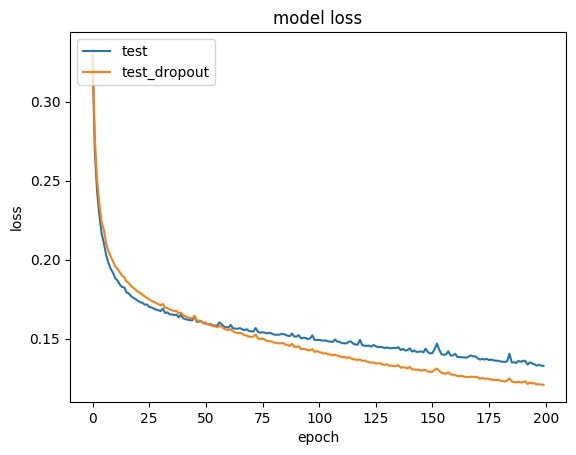

In [34]:
# summarize history for loss
plt.plot(history_1.history['val_loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test', 'test_dropout'], loc='upper left')
plt.show()

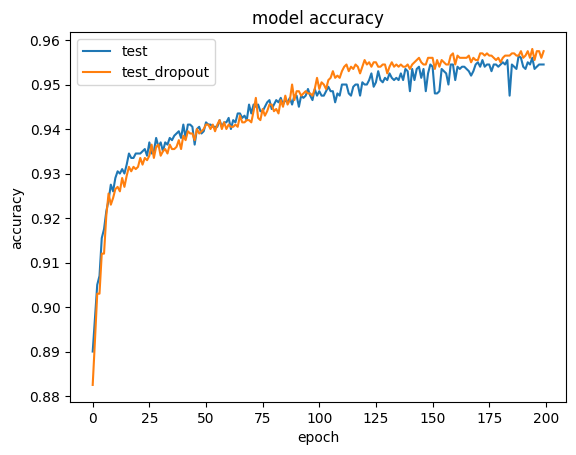

In [35]:
# summarize history for loss
plt.plot(history_1.history['val_accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test', 'test_dropout'], loc='upper left')
plt.show()

# Validation Set (The CORRECT way of training and evaluation process)

In [36]:
#cross validation example
from sklearn.model_selection import KFold

from tensorflow.keras.callbacks import ModelCheckpoint #save the model version that achieved lower loss!

kfold = KFold(n_splits=5, shuffle=True, random_state=2) # number of folds, shuffle, seed

In [44]:
# enumerate splits
fold = 1
for train, val in kfold.split(x_train_binary):
  print('train: %s, val: %s' % (train, val))
  X_train_binary = x_train_binary[train]
  Y_train_binary = y_train_binary[train]
  X_val_binary = x_train_binary[val]
  Y_val_binary = y_train_binary[val]

  seed = 2
  tf.random.set_seed(seed)
  np.random.seed(seed)

  model = Sequential()
  model.add(Dense(200, activation="relu"))
  model.add(Dropout(0.25))
  model.add(Dense(1, activation="sigmoid"))

  batch_size = 128
  epochs = 20

  save_model = ModelCheckpoint('best_model_'+str(fold)+'.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)

  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
  history_3 = model.fit(X_train_binary, Y_train_binary, batch_size=batch_size, epochs=epochs, callbacks=[save_model],
            validation_data=(X_val_binary, Y_val_binary))
  fold+=1

train: [    0     1     3 ... 11997 11998 11999], val: [    2     4    10 ... 11991 11992 11994]
Epoch 1/20
59/75 [======================>.......] - ETA: 0s - loss: 0.2298 - accuracy: 0.9082
Epoch 1: val_loss improved from inf to 0.16141, saving model to best_model_1.h5
75/75 [==============================] - 1s 6ms/step - loss: 0.2266 - accuracy: 0.9100 - val_loss: 0.1614 - val_accuracy: 0.9371
Epoch 2/20
56/75 [=====================>........] - ETA: 0s - loss: 0.1713 - accuracy: 0.9371

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/75 [===========================>..] - ETA: 0s - loss: 0.1744 - accuracy: 0.9362
Epoch 2: val_loss improved from 0.16141 to 0.14355, saving model to best_model_1.h5
75/75 [==============================] - 0s 4ms/step - loss: 0.1727 - accuracy: 0.9362 - val_loss: 0.1436 - val_accuracy: 0.9479
Epoch 3/20
59/75 [======================>.......] - ETA: 0s - loss: 0.1550 - accuracy: 0.9409
Epoch 3: val_loss improved from 0.14355 to 0.12733, saving model to best_model_1.h5
75/75 [==============================] - 0s 4ms/step - loss: 0.1532 - accuracy: 0.9399 - val_loss: 0.1273 - val_accuracy: 0.9500
Epoch 4/20
61/75 [=======================>......] - ETA: 0s - loss: 0.1396 - accuracy: 0.9484
Epoch 4: val_loss did not improve from 0.12733
75/75 [==============================] - 0s 4ms/step - loss: 0.1375 - accuracy: 0.9484 - val_loss: 0.1276 - val_accuracy: 0.9504
Epoch 5/20
59/75 [======================>.......] - ETA: 0s - loss: 0.1327 - accuracy: 0.9503
Epoch 5: val_loss improved from 0

In [45]:
print(np.mean(np.round(history_3.model.predict(X_val_binary))==Y_val_binary.reshape(-1,1)))
print(np.mean(np.round(history_3.model.predict(x_test_binary))==y_test_binary.reshape(-1,1)))

75/75 [==============================] - 0s 2ms/step
0.9666666666666667
63/63 [==============================] - 0s 2ms/step
0.963


In [46]:
history_3.model.load_weights('best_model_'+str(5)+'.h5')
print(np.mean(np.round(history_3.model.predict(X_val_binary))==Y_val_binary.reshape(-1,1)))
print(np.mean(np.round(history_3.model.predict(x_test_binary))==y_test_binary.reshape(-1,1)))

75/75 [==============================] - 0s 2ms/step
0.9683333333333334
63/63 [==============================] - 0s 2ms/step
0.962


#Automatic hyperparameter search platform -> wandb sweeps

example_1: https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb

example_2: https://colab.research.google.com/drive/181GCGp36_75C2zm7WLxr9U2QjMXXoibt

TO DO:
Using grid search and x[:10000] as val set, so x[10000:] as training execute a dummy hyperparameter on the multiclass classification task (not binary).
Search for 100 epochs:
1. layers: [64, 96, 128]
2. learning rate: [0.001, 0.003, 0.005]
3. dropout: [0.3, 0.4, 0.5]
4. minimize loss

In [47]:
# WandB – Install the W&B library
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline

!pip install wandb -qq
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,EarlyStopping

!wandb login --relogin
wandb.login() #just click the link and copy paste the pass

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: pkasnesis. Use `wandb login --relogin` to force relogin


True

In [49]:
sweep_config = {
    'method': 'grid'
    }

In [50]:
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

In [51]:
parameters_dict = {
 'learning-rate':{
        'values': [0.001, 0.003, 0.005]
        },
    'fc_layer_size': {
        'values': [128, 256, 512]
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict

In [52]:
parameters_dict.update({
    'epochs': {
        'value': 100}
    })

In [53]:
import pprint

pprint.pprint(sweep_config)

{'method': 'grid',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'dropout': {'values': [0.3, 0.4, 0.5]},
                'epochs': {'value': 100},
                'fc_layer_size': {'values': [128, 256, 512]},
                'learning-rate': {'values': [0.001, 0.003, 0.005]}}}


In [54]:
sweep_id = wandb.sweep(sweep_config, entity="pkasnesis", project="aidl-a02-week5")

Create sweep with ID: 846jlb6t
Sweep URL: https://wandb.ai/pkasnesis/aidl-a02-week5/sweeps/846jlb6t


In [55]:
X_val = x_train[:10000]
X_train = x_train[10000:]
X_test = x_test

Y_train = tf.keras.utils.to_categorical(y_train[10000:],10)
Y_val = tf.keras.utils.to_categorical(y_train[:10000],10)
Y_test = tf.keras.utils.to_categorical(y_test,10)

In [56]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'learning_rate': 1e-3,
        'dropout': 0.3,
        'fc_layer_size': 128,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)

    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Define the model architecture
    model = Sequential()
    model.add(Dense(config.fc_layer_size, activation="relu", input_shape=(x_train.shape[1],)))
    model.add(Dropout(config.dropout))
    model.add(Dense(10, activation="softmax"))

    batch_size = 128

    #save_model = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
    adam = tf.keras.optimizers.Adam(lr=config.learning_rate)

    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
    model.fit(X_train, Y_train, batch_size=batch_size,
              epochs=config.epochs,
              validation_data=(X_val, Y_val),
              callbacks=[WandbCallback(validation_data=(X_val, Y_val), labels=classes),
                          ])#EarlyStopping(patience=10, restore_best_weights=True)


In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: q4vov1jt with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	fc_layer_size: 128
wandb: 	learning-rate: 0.001


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
389/391 [============================>.] - ETA: 0s - loss: 0.6471 - accuracy: 0.7743

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_133847-q4vov1jt/files/model-best)... Done. 0.0s


391/391 [==============================] - 4s 6ms/step - loss: 0.6467 - accuracy: 0.7744 - val_loss: 0.4497 - val_accuracy: 0.8411
Epoch 2/100
386/391 [============================>.] - ETA: 0s - loss: 0.4582 - accuracy: 0.8382

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_133847-q4vov1jt/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.4572 - accuracy: 0.8388 - val_loss: 0.4004 - val_accuracy: 0.8562
Epoch 3/100
387/391 [============================>.] - ETA: 0s - loss: 0.4136 - accuracy: 0.8521

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_133847-q4vov1jt/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.4141 - accuracy: 0.8518 - val_loss: 0.3905 - val_accuracy: 0.8585
Epoch 4/100
381/391 [============================>.] - ETA: 0s - loss: 0.3893 - accuracy: 0.8609

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_133847-q4vov1jt/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3890 - accuracy: 0.8610 - val_loss: 0.3556 - val_accuracy: 0.8706
Epoch 5/100
384/391 [============================>.] - ETA: 0s - loss: 0.3694 - accuracy: 0.8677

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_133847-q4vov1jt/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3694 - accuracy: 0.8679 - val_loss: 0.3460 - val_accuracy: 0.8746
Epoch 6/100
391/391 [==============================] - 1s 4ms/step - loss: 0.3580 - accuracy: 0.8714 - val_loss: 0.3549 - val_accuracy: 0.8713
Epoch 7/100
386/391 [============================>.] - ETA: 0s - loss: 0.3433 - accuracy: 0.8766

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_133847-q4vov1jt/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.3436 - accuracy: 0.8767 - val_loss: 0.3312 - val_accuracy: 0.8778
Epoch 8/100
391/391 [==============================] - 1s 4ms/step - loss: 0.3323 - accuracy: 0.8812 - val_loss: 0.3344 - val_accuracy: 0.8760
Epoch 9/100
390/391 [============================>.] - ETA: 0s - loss: 0.3236 - accuracy: 0.8792

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_133847-q4vov1jt/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 8ms/step - loss: 0.3236 - accuracy: 0.8792 - val_loss: 0.3182 - val_accuracy: 0.8841
Epoch 10/100
389/391 [============================>.] - ETA: 0s - loss: 0.3177 - accuracy: 0.8838

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_133847-q4vov1jt/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 8ms/step - loss: 0.3177 - accuracy: 0.8838 - val_loss: 0.3145 - val_accuracy: 0.8848
Epoch 11/100
391/391 [==============================] - ETA: 0s - loss: 0.3084 - accuracy: 0.8867

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_133847-q4vov1jt/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3084 - accuracy: 0.8867 - val_loss: 0.3142 - val_accuracy: 0.8826
Epoch 12/100
385/391 [============================>.] - ETA: 0s - loss: 0.3044 - accuracy: 0.8876

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_133847-q4vov1jt/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 8ms/step - loss: 0.3047 - accuracy: 0.8876 - val_loss: 0.3116 - val_accuracy: 0.8857
Epoch 13/100
379/391 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.8905

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_133847-q4vov1jt/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.2977 - accuracy: 0.8905 - val_loss: 0.3058 - val_accuracy: 0.8882
Epoch 14/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2894 - accuracy: 0.8934 - val_loss: 0.3074 - val_accuracy: 0.8894
Epoch 15/100
382/391 [============================>.] - ETA: 0s - loss: 0.2859 - accuracy: 0.8949

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_133847-q4vov1jt/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.2852 - accuracy: 0.8952 - val_loss: 0.3039 - val_accuracy: 0.8923
Epoch 16/100
378/391 [============================>.] - ETA: 0s - loss: 0.2823 - accuracy: 0.8941

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_133847-q4vov1jt/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2823 - accuracy: 0.8941 - val_loss: 0.2970 - val_accuracy: 0.8913
Epoch 17/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2764 - accuracy: 0.8973 - val_loss: 0.3151 - val_accuracy: 0.8861
Epoch 18/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2713 - accuracy: 0.9000 - val_loss: 0.3039 - val_accuracy: 0.8880
Epoch 19/100
391/391 [==============================] - 1s 3ms/step - loss: 0.2712 - accuracy: 0.8983 - val_loss: 0.3021 - val_accuracy: 0.8907
Epoch 20/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2635 - accuracy: 0.9011 - val_loss: 0.3061 - val_accuracy: 0.8895
Epoch 21/100
391/391 [==============================] - ETA: 0s - loss: 0.2607 - accuracy: 0.9028

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_133847-q4vov1jt/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2607 - accuracy: 0.9028 - val_loss: 0.2957 - val_accuracy: 0.8946
Epoch 22/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2547 - accuracy: 0.9054 - val_loss: 0.3014 - val_accuracy: 0.8925
Epoch 23/100
386/391 [============================>.] - ETA: 0s - loss: 0.2535 - accuracy: 0.9040

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_133847-q4vov1jt/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2534 - accuracy: 0.9040 - val_loss: 0.2911 - val_accuracy: 0.8956
Epoch 24/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2527 - accuracy: 0.9067 - val_loss: 0.3029 - val_accuracy: 0.8910
Epoch 25/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2483 - accuracy: 0.9055 - val_loss: 0.2975 - val_accuracy: 0.8957
Epoch 26/100
391/391 [==============================] - 1s 3ms/step - loss: 0.2424 - accuracy: 0.9095 - val_loss: 0.2994 - val_accuracy: 0.8949
Epoch 27/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2409 - accuracy: 0.9092 - val_loss: 0.2962 - val_accuracy: 0.8942
Epoch 28/100
391/391 [==============================] - 1s 3ms/step - loss: 0.2387 - accuracy: 0.9097 - val_loss: 0.2971 - val_accuracy: 0.8952
Epoch 29/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2365 - accuracy: 0.9101 - val_loss: 0.2978 - val_accuracy: 0.8938
Epoch

accuracy,▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▆▇▇▇██████▇██▇█▇▇██▇██████████▇▇█▇▇█
val_loss,█▅▄▃▂▂▁▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▂▃▃▃▃▃▄▄▄▄▅▄▅▆▅▅
accuracy,0.94386
best_epoch,22
best_val_loss,0.29106
epoch,99
loss,0.14616
val_accuracy,0.8957


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2zdm2cpo with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	fc_layer_size: 128
wandb: 	learning-rate: 0.003


Epoch 1/100
  1/391 [..............................] - ETA: 6:34 - loss: 2.5069 - accuracy: 0.0781

387/391 [============================>.] - ETA: 0s - loss: 0.6554 - accuracy: 0.7742

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134200-2zdm2cpo/files/model-best)... Done. 0.0s


391/391 [==============================] - 4s 7ms/step - loss: 0.6541 - accuracy: 0.7746 - val_loss: 0.4438 - val_accuracy: 0.8455
Epoch 2/100
379/391 [============================>.] - ETA: 0s - loss: 0.4539 - accuracy: 0.8392

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134200-2zdm2cpo/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.4527 - accuracy: 0.8399 - val_loss: 0.3965 - val_accuracy: 0.8586
Epoch 3/100
377/391 [===========================>..] - ETA: 0s - loss: 0.4104 - accuracy: 0.8539

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134200-2zdm2cpo/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.4119 - accuracy: 0.8532 - val_loss: 0.3866 - val_accuracy: 0.8624
Epoch 4/100
389/391 [============================>.] - ETA: 0s - loss: 0.3869 - accuracy: 0.8614

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134200-2zdm2cpo/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.3867 - accuracy: 0.8615 - val_loss: 0.3497 - val_accuracy: 0.8741
Epoch 5/100
391/391 [==============================] - 2s 4ms/step - loss: 0.3639 - accuracy: 0.8686 - val_loss: 0.3549 - val_accuracy: 0.8720
Epoch 6/100
391/391 [==============================] - 2s 5ms/step - loss: 0.3557 - accuracy: 0.8717 - val_loss: 0.3576 - val_accuracy: 0.8694
Epoch 7/100
387/391 [============================>.] - ETA: 0s - loss: 0.3460 - accuracy: 0.8756

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134200-2zdm2cpo/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3462 - accuracy: 0.8755 - val_loss: 0.3286 - val_accuracy: 0.8803
Epoch 8/100
380/391 [============================>.] - ETA: 0s - loss: 0.3333 - accuracy: 0.8789

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134200-2zdm2cpo/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3331 - accuracy: 0.8791 - val_loss: 0.3181 - val_accuracy: 0.8844
Epoch 9/100
391/391 [==============================] - 2s 4ms/step - loss: 0.3225 - accuracy: 0.8823 - val_loss: 0.3189 - val_accuracy: 0.8852
Epoch 10/100
389/391 [============================>.] - ETA: 0s - loss: 0.3166 - accuracy: 0.8841

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134200-2zdm2cpo/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3166 - accuracy: 0.8841 - val_loss: 0.3156 - val_accuracy: 0.8839
Epoch 11/100
391/391 [==============================] - 2s 4ms/step - loss: 0.3086 - accuracy: 0.8876 - val_loss: 0.3198 - val_accuracy: 0.8822
Epoch 12/100
382/391 [============================>.] - ETA: 0s - loss: 0.3010 - accuracy: 0.8900

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134200-2zdm2cpo/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.3012 - accuracy: 0.8896 - val_loss: 0.3128 - val_accuracy: 0.8828
Epoch 13/100
388/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8894

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134200-2zdm2cpo/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.2990 - accuracy: 0.8895 - val_loss: 0.3065 - val_accuracy: 0.8880
Epoch 14/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2931 - accuracy: 0.8905 - val_loss: 0.3096 - val_accuracy: 0.8871
Epoch 15/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2887 - accuracy: 0.8935 - val_loss: 0.3070 - val_accuracy: 0.8890
Epoch 16/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2858 - accuracy: 0.8949 - val_loss: 0.3083 - val_accuracy: 0.8870
Epoch 17/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2796 - accuracy: 0.8972 - val_loss: 0.3123 - val_accuracy: 0.8857
Epoch 18/100
377/391 [===========================>..] - ETA: 0s - loss: 0.2731 - accuracy: 0.8997

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134200-2zdm2cpo/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2729 - accuracy: 0.8997 - val_loss: 0.3036 - val_accuracy: 0.8860
Epoch 19/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2693 - accuracy: 0.9003 - val_loss: 0.3037 - val_accuracy: 0.8881
Epoch 20/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2665 - accuracy: 0.9014 - val_loss: 0.3081 - val_accuracy: 0.8883
Epoch 21/100
380/391 [============================>.] - ETA: 0s - loss: 0.2649 - accuracy: 0.9019

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134200-2zdm2cpo/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.2649 - accuracy: 0.9020 - val_loss: 0.3016 - val_accuracy: 0.8916
Epoch 22/100
385/391 [============================>.] - ETA: 0s - loss: 0.2613 - accuracy: 0.9039

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134200-2zdm2cpo/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.2616 - accuracy: 0.9038 - val_loss: 0.3003 - val_accuracy: 0.8947
Epoch 23/100
386/391 [============================>.] - ETA: 0s - loss: 0.2563 - accuracy: 0.9043

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134200-2zdm2cpo/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.2564 - accuracy: 0.9044 - val_loss: 0.2969 - val_accuracy: 0.8938
Epoch 24/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2524 - accuracy: 0.9057 - val_loss: 0.2972 - val_accuracy: 0.8913
Epoch 25/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2487 - accuracy: 0.9068 - val_loss: 0.3000 - val_accuracy: 0.8955
Epoch 26/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2496 - accuracy: 0.9062 - val_loss: 0.2997 - val_accuracy: 0.8944
Epoch 27/100
388/391 [============================>.] - ETA: 0s - loss: 0.2471 - accuracy: 0.9081

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134200-2zdm2cpo/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.2468 - accuracy: 0.9083 - val_loss: 0.2917 - val_accuracy: 0.8956
Epoch 28/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2432 - accuracy: 0.9097 - val_loss: 0.3037 - val_accuracy: 0.8924
Epoch 29/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2390 - accuracy: 0.9099 - val_loss: 0.2971 - val_accuracy: 0.8925
Epoch 30/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2377 - accuracy: 0.9105 - val_loss: 0.2934 - val_accuracy: 0.8939
Epoch 31/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2334 - accuracy: 0.9136 - val_loss: 0.2999 - val_accuracy: 0.8930
Epoch 32/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2306 - accuracy: 0.9138 - val_loss: 0.3044 - val_accuracy: 0.8910
Epoch 33/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2293 - accuracy: 0.9137 - val_loss: 0.2981 - val_accuracy: 0.8946
Epoch

accuracy,▁▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇▆▇██▇▇▇███▇███████████████▇██████
val_loss,█▅▄▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅
accuracy,0.94344
best_epoch,26
best_val_loss,0.29173
epoch,99
loss,0.14681
val_accuracy,0.8973


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5ovcw5av with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	fc_layer_size: 128
wandb: 	learning-rate: 0.005


Epoch 1/100
377/391 [===========================>..] - ETA: 0s - loss: 0.6522 - accuracy: 0.7757

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134513-5ovcw5av/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 6ms/step - loss: 0.6467 - accuracy: 0.7772 - val_loss: 0.4479 - val_accuracy: 0.8421
Epoch 2/100
382/391 [============================>.] - ETA: 0s - loss: 0.4509 - accuracy: 0.8414

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134513-5ovcw5av/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 8ms/step - loss: 0.4498 - accuracy: 0.8418 - val_loss: 0.3978 - val_accuracy: 0.8564
Epoch 3/100
389/391 [============================>.] - ETA: 0s - loss: 0.4067 - accuracy: 0.8542

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134513-5ovcw5av/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.4070 - accuracy: 0.8540 - val_loss: 0.3880 - val_accuracy: 0.8581
Epoch 4/100
384/391 [============================>.] - ETA: 0s - loss: 0.3815 - accuracy: 0.8635

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134513-5ovcw5av/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.3812 - accuracy: 0.8635 - val_loss: 0.3487 - val_accuracy: 0.8738
Epoch 5/100
391/391 [==============================] - 2s 4ms/step - loss: 0.3618 - accuracy: 0.8694 - val_loss: 0.3515 - val_accuracy: 0.8729
Epoch 6/100
387/391 [============================>.] - ETA: 0s - loss: 0.3508 - accuracy: 0.8727

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134513-5ovcw5av/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3506 - accuracy: 0.8727 - val_loss: 0.3429 - val_accuracy: 0.8772
Epoch 7/100
384/391 [============================>.] - ETA: 0s - loss: 0.3391 - accuracy: 0.8779

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134513-5ovcw5av/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3388 - accuracy: 0.8779 - val_loss: 0.3313 - val_accuracy: 0.8801
Epoch 8/100
380/391 [============================>.] - ETA: 0s - loss: 0.3297 - accuracy: 0.8802

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134513-5ovcw5av/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.3297 - accuracy: 0.8802 - val_loss: 0.3245 - val_accuracy: 0.8835
Epoch 9/100
385/391 [============================>.] - ETA: 0s - loss: 0.3183 - accuracy: 0.8836

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134513-5ovcw5av/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.3177 - accuracy: 0.8838 - val_loss: 0.3137 - val_accuracy: 0.8881
Epoch 10/100
377/391 [===========================>..] - ETA: 0s - loss: 0.3116 - accuracy: 0.8865

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134513-5ovcw5av/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.3114 - accuracy: 0.8864 - val_loss: 0.3076 - val_accuracy: 0.8853
Epoch 11/100
391/391 [==============================] - 1s 4ms/step - loss: 0.3040 - accuracy: 0.8884 - val_loss: 0.3211 - val_accuracy: 0.8857
Epoch 12/100
391/391 [==============================] - 1s 4ms/step - loss: 0.3004 - accuracy: 0.8904 - val_loss: 0.3140 - val_accuracy: 0.8842
Epoch 13/100
382/391 [============================>.] - ETA: 0s - loss: 0.2949 - accuracy: 0.8912

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134513-5ovcw5av/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2942 - accuracy: 0.8915 - val_loss: 0.3065 - val_accuracy: 0.8882
Epoch 14/100
387/391 [============================>.] - ETA: 0s - loss: 0.2888 - accuracy: 0.8931

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134513-5ovcw5av/files/model-best)... Done. 0.0s


391/391 [==============================] - 4s 10ms/step - loss: 0.2884 - accuracy: 0.8931 - val_loss: 0.3020 - val_accuracy: 0.8877
Epoch 15/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2858 - accuracy: 0.8955 - val_loss: 0.3147 - val_accuracy: 0.8882
Epoch 16/100
391/391 [==============================] - 1s 3ms/step - loss: 0.2776 - accuracy: 0.8977 - val_loss: 0.3064 - val_accuracy: 0.8922
Epoch 17/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2733 - accuracy: 0.8989 - val_loss: 0.3056 - val_accuracy: 0.8908
Epoch 18/100
391/391 [==============================] - ETA: 0s - loss: 0.2665 - accuracy: 0.9000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134513-5ovcw5av/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.2665 - accuracy: 0.9000 - val_loss: 0.3015 - val_accuracy: 0.8879
Epoch 19/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2669 - accuracy: 0.9008 - val_loss: 0.3016 - val_accuracy: 0.8899
Epoch 20/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2628 - accuracy: 0.9018 - val_loss: 0.3069 - val_accuracy: 0.8888
Epoch 21/100
378/391 [============================>.] - ETA: 0s - loss: 0.2601 - accuracy: 0.9026

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134513-5ovcw5av/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.2604 - accuracy: 0.9026 - val_loss: 0.2996 - val_accuracy: 0.8959
Epoch 22/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2554 - accuracy: 0.9039 - val_loss: 0.3021 - val_accuracy: 0.8940
Epoch 23/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2504 - accuracy: 0.9067 - val_loss: 0.3011 - val_accuracy: 0.8932
Epoch 24/100
381/391 [============================>.] - ETA: 0s - loss: 0.2477 - accuracy: 0.9086

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134513-5ovcw5av/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2482 - accuracy: 0.9082 - val_loss: 0.2983 - val_accuracy: 0.8952
Epoch 25/100
383/391 [============================>.] - ETA: 0s - loss: 0.2455 - accuracy: 0.9094

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134513-5ovcw5av/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2454 - accuracy: 0.9093 - val_loss: 0.2948 - val_accuracy: 0.8949
Epoch 26/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2433 - accuracy: 0.9082 - val_loss: 0.2994 - val_accuracy: 0.8929
Epoch 27/100
384/391 [============================>.] - ETA: 0s - loss: 0.2370 - accuracy: 0.9118

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134513-5ovcw5av/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.2367 - accuracy: 0.9121 - val_loss: 0.2943 - val_accuracy: 0.8972
Epoch 28/100
391/391 [==============================] - 1s 3ms/step - loss: 0.2379 - accuracy: 0.9112 - val_loss: 0.3081 - val_accuracy: 0.8935
Epoch 29/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2368 - accuracy: 0.9106 - val_loss: 0.3015 - val_accuracy: 0.8917
Epoch 30/100
391/391 [==============================] - 1s 3ms/step - loss: 0.2336 - accuracy: 0.9125 - val_loss: 0.3093 - val_accuracy: 0.8937
Epoch 31/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2304 - accuracy: 0.9143 - val_loss: 0.3051 - val_accuracy: 0.8936
Epoch 32/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2254 - accuracy: 0.9153 - val_loss: 0.3069 - val_accuracy: 0.8943
Epoch 33/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2254 - accuracy: 0.9150 - val_loss: 0.3011 - val_accuracy: 0.8960
Epoch

accuracy,▁▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▆▇▇▇█▇▇▇▇▇███▇█████▇██▇█████▇█▇▇████
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▃▅▄▄▄▄▅
accuracy,0.94544
best_epoch,26
best_val_loss,0.29433
epoch,99
loss,0.14102
val_accuracy,0.8987


wandb: Agent Starting Run: c0yekmt7 with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	fc_layer_size: 256
wandb: 	learning-rate: 0.001


Epoch 1/100
382/391 [============================>.] - ETA: 0s - loss: 0.5969 - accuracy: 0.7918

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134851-c0yekmt7/files/model-best)... Done. 0.0s


391/391 [==============================] - 4s 8ms/step - loss: 0.5938 - accuracy: 0.7928 - val_loss: 0.4270 - val_accuracy: 0.8523
Epoch 2/100
388/391 [============================>.] - ETA: 0s - loss: 0.4241 - accuracy: 0.8486

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134851-c0yekmt7/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.4241 - accuracy: 0.8488 - val_loss: 0.3856 - val_accuracy: 0.8612
Epoch 3/100
391/391 [==============================] - 2s 4ms/step - loss: 0.3837 - accuracy: 0.8611 - val_loss: 0.3878 - val_accuracy: 0.8580
Epoch 4/100
374/391 [===========================>..] - ETA: 0s - loss: 0.3582 - accuracy: 0.8705

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134851-c0yekmt7/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.3574 - accuracy: 0.8708 - val_loss: 0.3349 - val_accuracy: 0.8788
Epoch 5/100
377/391 [===========================>..] - ETA: 0s - loss: 0.3398 - accuracy: 0.8761

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134851-c0yekmt7/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.3392 - accuracy: 0.8763 - val_loss: 0.3347 - val_accuracy: 0.8778
Epoch 6/100
378/391 [============================>.] - ETA: 0s - loss: 0.3297 - accuracy: 0.8788

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134851-c0yekmt7/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3300 - accuracy: 0.8787 - val_loss: 0.3245 - val_accuracy: 0.8836
Epoch 7/100
380/391 [============================>.] - ETA: 0s - loss: 0.3177 - accuracy: 0.8822

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134851-c0yekmt7/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.3182 - accuracy: 0.8818 - val_loss: 0.3162 - val_accuracy: 0.8830
Epoch 8/100
391/391 [==============================] - 2s 4ms/step - loss: 0.3057 - accuracy: 0.8891 - val_loss: 0.3179 - val_accuracy: 0.8828
Epoch 9/100
389/391 [============================>.] - ETA: 0s - loss: 0.2985 - accuracy: 0.8894

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134851-c0yekmt7/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2984 - accuracy: 0.8895 - val_loss: 0.3078 - val_accuracy: 0.8867
Epoch 10/100
375/391 [===========================>..] - ETA: 0s - loss: 0.2875 - accuracy: 0.8947

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134851-c0yekmt7/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.2884 - accuracy: 0.8941 - val_loss: 0.2976 - val_accuracy: 0.8926
Epoch 11/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2835 - accuracy: 0.8954 - val_loss: 0.3046 - val_accuracy: 0.8892
Epoch 12/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2737 - accuracy: 0.8978 - val_loss: 0.2989 - val_accuracy: 0.8889
Epoch 13/100
382/391 [============================>.] - ETA: 0s - loss: 0.2685 - accuracy: 0.9001

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134851-c0yekmt7/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.2678 - accuracy: 0.9004 - val_loss: 0.2953 - val_accuracy: 0.8916
Epoch 14/100
389/391 [============================>.] - ETA: 0s - loss: 0.2666 - accuracy: 0.9012

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134851-c0yekmt7/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2664 - accuracy: 0.9011 - val_loss: 0.2943 - val_accuracy: 0.8925
Epoch 15/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2578 - accuracy: 0.9044 - val_loss: 0.2954 - val_accuracy: 0.8929
Epoch 16/100
381/391 [============================>.] - ETA: 0s - loss: 0.2541 - accuracy: 0.9057

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134851-c0yekmt7/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2544 - accuracy: 0.9056 - val_loss: 0.2876 - val_accuracy: 0.8938
Epoch 17/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2470 - accuracy: 0.9087 - val_loss: 0.2932 - val_accuracy: 0.8958
Epoch 18/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2472 - accuracy: 0.9070 - val_loss: 0.2905 - val_accuracy: 0.8937
Epoch 19/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2395 - accuracy: 0.9103 - val_loss: 0.2994 - val_accuracy: 0.8907
Epoch 20/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2339 - accuracy: 0.9108 - val_loss: 0.3065 - val_accuracy: 0.8837
Epoch 21/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2333 - accuracy: 0.9123 - val_loss: 0.2952 - val_accuracy: 0.8946
Epoch 22/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2285 - accuracy: 0.9134 - val_loss: 0.2890 - val_accuracy: 0.8965
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134851-c0yekmt7/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2236 - accuracy: 0.9160 - val_loss: 0.2860 - val_accuracy: 0.9005
Epoch 24/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2208 - accuracy: 0.9174 - val_loss: 0.2956 - val_accuracy: 0.8958
Epoch 25/100
386/391 [============================>.] - ETA: 0s - loss: 0.2178 - accuracy: 0.9175

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_134851-c0yekmt7/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2174 - accuracy: 0.9176 - val_loss: 0.2838 - val_accuracy: 0.8986
Epoch 26/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2138 - accuracy: 0.9196 - val_loss: 0.2861 - val_accuracy: 0.8970
Epoch 27/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2128 - accuracy: 0.9194 - val_loss: 0.2885 - val_accuracy: 0.8977
Epoch 28/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2098 - accuracy: 0.9210 - val_loss: 0.2918 - val_accuracy: 0.8987
Epoch 29/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2044 - accuracy: 0.9231 - val_loss: 0.2939 - val_accuracy: 0.8953
Epoch 30/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2002 - accuracy: 0.9241 - val_loss: 0.2884 - val_accuracy: 0.8954
Epoch 31/100
391/391 [==============================] - 2s 4ms/step - loss: 0.1974 - accuracy: 0.9254 - val_loss: 0.2894 - val_accuracy: 0.8978
Epoch

accuracy,▁▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▅▆▆▇▇▇█▇▇▇▇▇█▇▇▇▇▇▇█▇███▇█████▇▇█▇███
val_loss,█▆▃▃▂▁▁▁▁▁▁▁▁▂▂▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▆▅▆▆▆▆▆▇
accuracy,0.9601
best_epoch,24
best_val_loss,0.28378
epoch,99
loss,0.10504
val_accuracy,0.9037


wandb: Agent Starting Run: hed5zhpe with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	fc_layer_size: 256
wandb: 	learning-rate: 0.003


Epoch 1/100
390/391 [============================>.] - ETA: 0s - loss: 0.5931 - accuracy: 0.7911

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135202-hed5zhpe/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 6ms/step - loss: 0.5932 - accuracy: 0.7910 - val_loss: 0.4286 - val_accuracy: 0.8498
Epoch 2/100
378/391 [============================>.] - ETA: 0s - loss: 0.4263 - accuracy: 0.8477

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135202-hed5zhpe/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.4248 - accuracy: 0.8483 - val_loss: 0.3809 - val_accuracy: 0.8627
Epoch 3/100
383/391 [============================>.] - ETA: 0s - loss: 0.3816 - accuracy: 0.8632

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135202-hed5zhpe/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3818 - accuracy: 0.8631 - val_loss: 0.3755 - val_accuracy: 0.8618
Epoch 4/100
389/391 [============================>.] - ETA: 0s - loss: 0.3574 - accuracy: 0.8710

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135202-hed5zhpe/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.3572 - accuracy: 0.8711 - val_loss: 0.3344 - val_accuracy: 0.8805
Epoch 5/100
391/391 [==============================] - 1s 4ms/step - loss: 0.3377 - accuracy: 0.8783 - val_loss: 0.3417 - val_accuracy: 0.8778
Epoch 6/100
376/391 [===========================>..] - ETA: 0s - loss: 0.3292 - accuracy: 0.8806

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135202-hed5zhpe/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.3296 - accuracy: 0.8804 - val_loss: 0.3254 - val_accuracy: 0.8822
Epoch 7/100
388/391 [============================>.] - ETA: 0s - loss: 0.3158 - accuracy: 0.8838

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135202-hed5zhpe/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.3160 - accuracy: 0.8837 - val_loss: 0.3214 - val_accuracy: 0.8827
Epoch 8/100
382/391 [============================>.] - ETA: 0s - loss: 0.3059 - accuracy: 0.8881

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135202-hed5zhpe/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3054 - accuracy: 0.8882 - val_loss: 0.3096 - val_accuracy: 0.8844
Epoch 9/100
382/391 [============================>.] - ETA: 0s - loss: 0.2980 - accuracy: 0.8911

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135202-hed5zhpe/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2978 - accuracy: 0.8910 - val_loss: 0.3072 - val_accuracy: 0.8877
Epoch 10/100
386/391 [============================>.] - ETA: 0s - loss: 0.2905 - accuracy: 0.8930

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135202-hed5zhpe/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.2904 - accuracy: 0.8930 - val_loss: 0.2986 - val_accuracy: 0.8902
Epoch 11/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2819 - accuracy: 0.8962 - val_loss: 0.3105 - val_accuracy: 0.8863
Epoch 12/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2756 - accuracy: 0.8986 - val_loss: 0.3077 - val_accuracy: 0.8860
Epoch 13/100
380/391 [============================>.] - ETA: 0s - loss: 0.2724 - accuracy: 0.8976

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135202-hed5zhpe/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.2720 - accuracy: 0.8978 - val_loss: 0.2927 - val_accuracy: 0.8927
Epoch 14/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2660 - accuracy: 0.9013 - val_loss: 0.2983 - val_accuracy: 0.8908
Epoch 15/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2605 - accuracy: 0.9024 - val_loss: 0.2983 - val_accuracy: 0.8938
Epoch 16/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2551 - accuracy: 0.9042 - val_loss: 0.2968 - val_accuracy: 0.8925
Epoch 17/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2476 - accuracy: 0.9081 - val_loss: 0.2955 - val_accuracy: 0.8937
Epoch 18/100
389/391 [============================>.] - ETA: 0s - loss: 0.2456 - accuracy: 0.9090

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135202-hed5zhpe/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2455 - accuracy: 0.9090 - val_loss: 0.2920 - val_accuracy: 0.8878
Epoch 19/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2421 - accuracy: 0.9089 - val_loss: 0.2959 - val_accuracy: 0.8926
Epoch 20/100
388/391 [============================>.] - ETA: 0s - loss: 0.2387 - accuracy: 0.9100

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135202-hed5zhpe/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.2387 - accuracy: 0.9101 - val_loss: 0.2919 - val_accuracy: 0.8927
Epoch 21/100
387/391 [============================>.] - ETA: 0s - loss: 0.2330 - accuracy: 0.9114

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135202-hed5zhpe/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2329 - accuracy: 0.9116 - val_loss: 0.2901 - val_accuracy: 0.8998
Epoch 22/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2298 - accuracy: 0.9140 - val_loss: 0.3009 - val_accuracy: 0.8929
Epoch 23/100
382/391 [============================>.] - ETA: 0s - loss: 0.2206 - accuracy: 0.9168

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135202-hed5zhpe/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.2208 - accuracy: 0.9168 - val_loss: 0.2793 - val_accuracy: 0.8989
Epoch 24/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2195 - accuracy: 0.9158 - val_loss: 0.2925 - val_accuracy: 0.8972
Epoch 25/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2186 - accuracy: 0.9179 - val_loss: 0.2877 - val_accuracy: 0.9001
Epoch 26/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2132 - accuracy: 0.9193 - val_loss: 0.2827 - val_accuracy: 0.9010
Epoch 27/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2118 - accuracy: 0.9193 - val_loss: 0.2887 - val_accuracy: 0.8985
Epoch 28/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2104 - accuracy: 0.9214 - val_loss: 0.2924 - val_accuracy: 0.8954
Epoch 29/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2041 - accuracy: 0.9225 - val_loss: 0.2918 - val_accuracy: 0.8957
Epoch

accuracy,▁▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▆▇▇▆█▇█▇▇▇▇██▇█▇█▇██▇▇█▇█████▇▇███▇█
val_loss,█▅▃▂▂▂▂▂▁▁▁▂▁▂▂▂▂▃▂▃▃▃▃▄▄▄▄▄▄▄▅▆▅▆▆▆▆▇▇█
accuracy,0.9616
best_epoch,22
best_val_loss,0.27933
epoch,99
loss,0.10088
val_accuracy,0.8999


wandb: Agent Starting Run: c4di01t1 with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	fc_layer_size: 256
wandb: 	learning-rate: 0.005


Epoch 1/100
383/391 [============================>.] - ETA: 0s - loss: 0.6019 - accuracy: 0.7907

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135544-c4di01t1/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 6ms/step - loss: 0.5990 - accuracy: 0.7916 - val_loss: 0.4244 - val_accuracy: 0.8508
Epoch 2/100
385/391 [============================>.] - ETA: 0s - loss: 0.4267 - accuracy: 0.8486

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135544-c4di01t1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.4257 - accuracy: 0.8489 - val_loss: 0.3860 - val_accuracy: 0.8585
Epoch 3/100
382/391 [============================>.] - ETA: 0s - loss: 0.3825 - accuracy: 0.8622

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135544-c4di01t1/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 6ms/step - loss: 0.3831 - accuracy: 0.8620 - val_loss: 0.3808 - val_accuracy: 0.8564
Epoch 4/100
385/391 [============================>.] - ETA: 0s - loss: 0.3570 - accuracy: 0.8725

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135544-c4di01t1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3569 - accuracy: 0.8724 - val_loss: 0.3326 - val_accuracy: 0.8791
Epoch 5/100
376/391 [===========================>..] - ETA: 0s - loss: 0.3385 - accuracy: 0.8772

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135544-c4di01t1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.3379 - accuracy: 0.8774 - val_loss: 0.3325 - val_accuracy: 0.8795
Epoch 6/100
380/391 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.8810

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135544-c4di01t1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.3258 - accuracy: 0.8810 - val_loss: 0.3249 - val_accuracy: 0.8847
Epoch 7/100
386/391 [============================>.] - ETA: 0s - loss: 0.3173 - accuracy: 0.8842

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135544-c4di01t1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3173 - accuracy: 0.8843 - val_loss: 0.3180 - val_accuracy: 0.8850
Epoch 8/100
377/391 [===========================>..] - ETA: 0s - loss: 0.3076 - accuracy: 0.8869

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135544-c4di01t1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.3074 - accuracy: 0.8870 - val_loss: 0.3125 - val_accuracy: 0.8858
Epoch 9/100
383/391 [============================>.] - ETA: 0s - loss: 0.2996 - accuracy: 0.8889

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135544-c4di01t1/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.2997 - accuracy: 0.8889 - val_loss: 0.3028 - val_accuracy: 0.8898
Epoch 10/100
388/391 [============================>.] - ETA: 0s - loss: 0.2892 - accuracy: 0.8922

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135544-c4di01t1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2892 - accuracy: 0.8923 - val_loss: 0.2991 - val_accuracy: 0.8904
Epoch 11/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2821 - accuracy: 0.8961 - val_loss: 0.3042 - val_accuracy: 0.8915
Epoch 12/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2783 - accuracy: 0.8968 - val_loss: 0.3016 - val_accuracy: 0.8892
Epoch 13/100
386/391 [============================>.] - ETA: 0s - loss: 0.2714 - accuracy: 0.8993

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135544-c4di01t1/files/model-best)... Done. 0.0s


391/391 [==============================] - 4s 10ms/step - loss: 0.2710 - accuracy: 0.8994 - val_loss: 0.2945 - val_accuracy: 0.8929
Epoch 14/100
389/391 [============================>.] - ETA: 0s - loss: 0.2662 - accuracy: 0.9008

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135544-c4di01t1/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.2661 - accuracy: 0.9008 - val_loss: 0.2923 - val_accuracy: 0.8976
Epoch 15/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2617 - accuracy: 0.9023 - val_loss: 0.3019 - val_accuracy: 0.8930
Epoch 16/100
377/391 [===========================>..] - ETA: 0s - loss: 0.2567 - accuracy: 0.9046

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135544-c4di01t1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.2568 - accuracy: 0.9047 - val_loss: 0.2918 - val_accuracy: 0.8946
Epoch 17/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2503 - accuracy: 0.9064 - val_loss: 0.3003 - val_accuracy: 0.8917
Epoch 18/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2487 - accuracy: 0.9076 - val_loss: 0.2993 - val_accuracy: 0.8906
Epoch 19/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2422 - accuracy: 0.9090 - val_loss: 0.2921 - val_accuracy: 0.8953
Epoch 20/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2359 - accuracy: 0.9115 - val_loss: 0.2987 - val_accuracy: 0.8905
Epoch 21/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2329 - accuracy: 0.9117 - val_loss: 0.2928 - val_accuracy: 0.8968
Epoch 22/100
377/391 [===========================>..] - ETA: 0s - loss: 0.2302 - accuracy: 0.9128

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135544-c4di01t1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2302 - accuracy: 0.9127 - val_loss: 0.2914 - val_accuracy: 0.8988
Epoch 23/100
382/391 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9161

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135544-c4di01t1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2247 - accuracy: 0.9164 - val_loss: 0.2830 - val_accuracy: 0.8999
Epoch 24/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2232 - accuracy: 0.9163 - val_loss: 0.2907 - val_accuracy: 0.8956
Epoch 25/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2191 - accuracy: 0.9175 - val_loss: 0.2863 - val_accuracy: 0.9007
Epoch 26/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2175 - accuracy: 0.9184 - val_loss: 0.2891 - val_accuracy: 0.8973
Epoch 27/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2137 - accuracy: 0.9195 - val_loss: 0.2883 - val_accuracy: 0.8980
Epoch 28/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2123 - accuracy: 0.9205 - val_loss: 0.2967 - val_accuracy: 0.8994
Epoch 29/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2052 - accuracy: 0.9225 - val_loss: 0.2940 - val_accuracy: 0.8958
Epoch

accuracy,▁▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▆▆▆▇▇▆▇█▇▇▇▇███▇▇██▇▇▇█▇████████▇█████
val_loss,█▆▃▂▂▂▁▂▁▁▁▂▁▂▁▂▂▃▃▂▂▃▃▃▃▄▃▄▄▄▅▅▅▅▆▆▆▆▆▇
accuracy,0.96026
best_epoch,22
best_val_loss,0.28299
epoch,99
loss,0.10595
val_accuracy,0.9023


wandb: Agent Starting Run: joh87sk1 with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	fc_layer_size: 512
wandb: 	learning-rate: 0.001


Epoch 1/100
386/391 [============================>.] - ETA: 0s - loss: 0.5587 - accuracy: 0.8047

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135857-joh87sk1/files/model-best)... Done. 0.0s


391/391 [==============================] - 4s 7ms/step - loss: 0.5573 - accuracy: 0.8052 - val_loss: 0.4138 - val_accuracy: 0.8559
Epoch 2/100
390/391 [============================>.] - ETA: 0s - loss: 0.4105 - accuracy: 0.8531

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135857-joh87sk1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.4106 - accuracy: 0.8531 - val_loss: 0.3776 - val_accuracy: 0.8612
Epoch 3/100
387/391 [============================>.] - ETA: 0s - loss: 0.3693 - accuracy: 0.8672

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135857-joh87sk1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3697 - accuracy: 0.8670 - val_loss: 0.3758 - val_accuracy: 0.8603
Epoch 4/100
381/391 [============================>.] - ETA: 0s - loss: 0.3477 - accuracy: 0.8739

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135857-joh87sk1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3472 - accuracy: 0.8738 - val_loss: 0.3365 - val_accuracy: 0.8754
Epoch 5/100
383/391 [============================>.] - ETA: 0s - loss: 0.3283 - accuracy: 0.8791

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135857-joh87sk1/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.3283 - accuracy: 0.8791 - val_loss: 0.3332 - val_accuracy: 0.8776
Epoch 6/100
380/391 [============================>.] - ETA: 0s - loss: 0.3175 - accuracy: 0.8830

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135857-joh87sk1/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 6ms/step - loss: 0.3174 - accuracy: 0.8830 - val_loss: 0.3154 - val_accuracy: 0.8856
Epoch 7/100
391/391 [==============================] - ETA: 0s - loss: 0.3076 - accuracy: 0.8870

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135857-joh87sk1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.3076 - accuracy: 0.8870 - val_loss: 0.3149 - val_accuracy: 0.8829
Epoch 8/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2921 - accuracy: 0.8923 - val_loss: 0.3205 - val_accuracy: 0.8824
Epoch 9/100
384/391 [============================>.] - ETA: 0s - loss: 0.2883 - accuracy: 0.8933

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135857-joh87sk1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2880 - accuracy: 0.8934 - val_loss: 0.3078 - val_accuracy: 0.8870
Epoch 10/100
381/391 [============================>.] - ETA: 0s - loss: 0.2793 - accuracy: 0.8973

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135857-joh87sk1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.2791 - accuracy: 0.8973 - val_loss: 0.2933 - val_accuracy: 0.8881
Epoch 11/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2703 - accuracy: 0.9001 - val_loss: 0.3022 - val_accuracy: 0.8883
Epoch 12/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2662 - accuracy: 0.9007 - val_loss: 0.2942 - val_accuracy: 0.8909
Epoch 13/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2587 - accuracy: 0.9024 - val_loss: 0.2977 - val_accuracy: 0.8922
Epoch 14/100
384/391 [============================>.] - ETA: 0s - loss: 0.2522 - accuracy: 0.9061

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135857-joh87sk1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2517 - accuracy: 0.9062 - val_loss: 0.2917 - val_accuracy: 0.8975
Epoch 15/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2480 - accuracy: 0.9070 - val_loss: 0.2953 - val_accuracy: 0.8951
Epoch 16/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2455 - accuracy: 0.9066 - val_loss: 0.2977 - val_accuracy: 0.8921
Epoch 17/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2359 - accuracy: 0.9114 - val_loss: 0.2975 - val_accuracy: 0.8926
Epoch 18/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2341 - accuracy: 0.9133 - val_loss: 0.2930 - val_accuracy: 0.8936
Epoch 19/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2298 - accuracy: 0.9140 - val_loss: 0.2952 - val_accuracy: 0.8929
Epoch 20/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2235 - accuracy: 0.9147 - val_loss: 0.3006 - val_accuracy: 0.8881
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135857-joh87sk1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.2088 - accuracy: 0.9210 - val_loss: 0.2890 - val_accuracy: 0.8986
Epoch 25/100
383/391 [============================>.] - ETA: 0s - loss: 0.2040 - accuracy: 0.9226

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135857-joh87sk1/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.2042 - accuracy: 0.9226 - val_loss: 0.2870 - val_accuracy: 0.8989
Epoch 26/100
380/391 [============================>.] - ETA: 0s - loss: 0.2000 - accuracy: 0.9249

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_135857-joh87sk1/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2008 - accuracy: 0.9247 - val_loss: 0.2764 - val_accuracy: 0.9033
Epoch 27/100
391/391 [==============================] - 1s 4ms/step - loss: 0.1968 - accuracy: 0.9259 - val_loss: 0.2908 - val_accuracy: 0.8983
Epoch 28/100
391/391 [==============================] - 2s 4ms/step - loss: 0.1935 - accuracy: 0.9261 - val_loss: 0.2967 - val_accuracy: 0.9008
Epoch 29/100
391/391 [==============================] - 2s 4ms/step - loss: 0.1916 - accuracy: 0.9274 - val_loss: 0.3047 - val_accuracy: 0.8949
Epoch 30/100
391/391 [==============================] - 1s 4ms/step - loss: 0.1838 - accuracy: 0.9311 - val_loss: 0.2906 - val_accuracy: 0.9001
Epoch 31/100
391/391 [==============================] - 1s 4ms/step - loss: 0.1836 - accuracy: 0.9297 - val_loss: 0.2999 - val_accuracy: 0.8951
Epoch 32/100
391/391 [==============================] - 2s 5ms/step - loss: 0.1822 - accuracy: 0.9310 - val_loss: 0.3012 - val_accuracy: 0.8987
Epoch

accuracy,▁▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▅▆▆▆▆▇▇█▇▆▇█▇▇█▇█▇█▇▆▇▇██▇▇▇▇▇▇▇▇▇▇▇▇
val_loss,▇▅▃▃▂▂▂▂▂▂▁▂▂▂▂▃▃▂▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇█
accuracy,0.96714
best_epoch,25
best_val_loss,0.27636
epoch,99
loss,0.08908
val_accuracy,0.9015


wandb: Agent Starting Run: 699xrad9 with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	fc_layer_size: 512
wandb: 	learning-rate: 0.003


Epoch 1/100
379/391 [============================>.] - ETA: 0s - loss: 0.5612 - accuracy: 0.8015

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140239-699xrad9/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 6ms/step - loss: 0.5574 - accuracy: 0.8024 - val_loss: 0.4138 - val_accuracy: 0.8541
Epoch 2/100
385/391 [============================>.] - ETA: 0s - loss: 0.4110 - accuracy: 0.8515

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140239-699xrad9/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.4098 - accuracy: 0.8521 - val_loss: 0.3730 - val_accuracy: 0.8644
Epoch 3/100
381/391 [============================>.] - ETA: 0s - loss: 0.3691 - accuracy: 0.8666

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140239-699xrad9/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3694 - accuracy: 0.8664 - val_loss: 0.3664 - val_accuracy: 0.8649
Epoch 4/100
390/391 [============================>.] - ETA: 0s - loss: 0.3470 - accuracy: 0.8741

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140239-699xrad9/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.3469 - accuracy: 0.8741 - val_loss: 0.3278 - val_accuracy: 0.8803
Epoch 5/100
376/391 [===========================>..] - ETA: 0s - loss: 0.3273 - accuracy: 0.8816

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140239-699xrad9/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.3270 - accuracy: 0.8818 - val_loss: 0.3276 - val_accuracy: 0.8821
Epoch 6/100
384/391 [============================>.] - ETA: 0s - loss: 0.3162 - accuracy: 0.8834

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140239-699xrad9/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.3161 - accuracy: 0.8834 - val_loss: 0.3106 - val_accuracy: 0.8897
Epoch 7/100
391/391 [==============================] - 1s 4ms/step - loss: 0.3102 - accuracy: 0.8850 - val_loss: 0.3291 - val_accuracy: 0.8796
Epoch 8/100
380/391 [============================>.] - ETA: 0s - loss: 0.2948 - accuracy: 0.8914

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140239-699xrad9/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2946 - accuracy: 0.8915 - val_loss: 0.3080 - val_accuracy: 0.8867
Epoch 9/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2880 - accuracy: 0.8928 - val_loss: 0.3087 - val_accuracy: 0.8890
Epoch 10/100
388/391 [============================>.] - ETA: 0s - loss: 0.2780 - accuracy: 0.8971

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140239-699xrad9/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.2781 - accuracy: 0.8971 - val_loss: 0.2915 - val_accuracy: 0.8918
Epoch 11/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2701 - accuracy: 0.9014 - val_loss: 0.2946 - val_accuracy: 0.8948
Epoch 12/100
378/391 [============================>.] - ETA: 0s - loss: 0.2621 - accuracy: 0.9021

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140239-699xrad9/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.2626 - accuracy: 0.9019 - val_loss: 0.2884 - val_accuracy: 0.8920
Epoch 13/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2586 - accuracy: 0.9039 - val_loss: 0.2930 - val_accuracy: 0.8937
Epoch 14/100
383/391 [============================>.] - ETA: 0s - loss: 0.2515 - accuracy: 0.9059

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140239-699xrad9/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2510 - accuracy: 0.9062 - val_loss: 0.2869 - val_accuracy: 0.8948
Epoch 15/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2457 - accuracy: 0.9094 - val_loss: 0.2976 - val_accuracy: 0.8940
Epoch 16/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2430 - accuracy: 0.9091 - val_loss: 0.2876 - val_accuracy: 0.8942
Epoch 17/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2332 - accuracy: 0.9127 - val_loss: 0.2882 - val_accuracy: 0.8936
Epoch 18/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2300 - accuracy: 0.9123 - val_loss: 0.2886 - val_accuracy: 0.8930
Epoch 19/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2273 - accuracy: 0.9149 - val_loss: 0.2912 - val_accuracy: 0.8942
Epoch 20/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2217 - accuracy: 0.9172 - val_loss: 0.3030 - val_accuracy: 0.8919
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140239-699xrad9/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2096 - accuracy: 0.9208 - val_loss: 0.2827 - val_accuracy: 0.8992
Epoch 24/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2069 - accuracy: 0.9221 - val_loss: 0.2898 - val_accuracy: 0.8985
Epoch 25/100
379/391 [============================>.] - ETA: 0s - loss: 0.2025 - accuracy: 0.9246

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140239-699xrad9/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2029 - accuracy: 0.9241 - val_loss: 0.2823 - val_accuracy: 0.8977
Epoch 26/100
391/391 [==============================] - 2s 4ms/step - loss: 0.1981 - accuracy: 0.9256 - val_loss: 0.2860 - val_accuracy: 0.8974
Epoch 27/100
391/391 [==============================] - 1s 4ms/step - loss: 0.1978 - accuracy: 0.9255 - val_loss: 0.2901 - val_accuracy: 0.8983
Epoch 28/100
391/391 [==============================] - 1s 4ms/step - loss: 0.1934 - accuracy: 0.9265 - val_loss: 0.2988 - val_accuracy: 0.8964
Epoch 29/100
391/391 [==============================] - 2s 4ms/step - loss: 0.1889 - accuracy: 0.9282 - val_loss: 0.2941 - val_accuracy: 0.8975
Epoch 30/100
391/391 [==============================] - 2s 4ms/step - loss: 0.1854 - accuracy: 0.9282 - val_loss: 0.3023 - val_accuracy: 0.8948
Epoch 31/100
391/391 [==============================] - 2s 5ms/step - loss: 0.1823 - accuracy: 0.9317 - val_loss: 0.3032 - val_accuracy: 0.8991
Epoch

accuracy,▁▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇█▇▇██████████████
val_loss,▇▅▂▂▂▁▁▁▂▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇█▇
accuracy,0.9648
best_epoch,24
best_val_loss,0.28229
epoch,99
loss,0.08994
val_accuracy,0.9018


wandb: Agent Starting Run: wxjgnm6e with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	fc_layer_size: 512
wandb: 	learning-rate: 0.005


Epoch 1/100
391/391 [==============================] - ETA: 0s - loss: 0.5580 - accuracy: 0.8043

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140622-wxjgnm6e/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 6ms/step - loss: 0.5580 - accuracy: 0.8043 - val_loss: 0.4124 - val_accuracy: 0.8571
Epoch 2/100
389/391 [============================>.] - ETA: 0s - loss: 0.4099 - accuracy: 0.8536

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140622-wxjgnm6e/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.4100 - accuracy: 0.8535 - val_loss: 0.3705 - val_accuracy: 0.8642
Epoch 3/100
391/391 [==============================] - 2s 5ms/step - loss: 0.3713 - accuracy: 0.8653 - val_loss: 0.3717 - val_accuracy: 0.8599
Epoch 4/100
383/391 [============================>.] - ETA: 0s - loss: 0.3485 - accuracy: 0.8745

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140622-wxjgnm6e/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3480 - accuracy: 0.8746 - val_loss: 0.3306 - val_accuracy: 0.8813
Epoch 5/100
391/391 [==============================] - 2s 4ms/step - loss: 0.3266 - accuracy: 0.8808 - val_loss: 0.3357 - val_accuracy: 0.8787
Epoch 6/100
389/391 [============================>.] - ETA: 0s - loss: 0.3163 - accuracy: 0.8839

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140622-wxjgnm6e/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.3163 - accuracy: 0.8838 - val_loss: 0.3196 - val_accuracy: 0.8850
Epoch 7/100
391/391 [==============================] - 1s 4ms/step - loss: 0.3064 - accuracy: 0.8869 - val_loss: 0.3226 - val_accuracy: 0.8805
Epoch 8/100
382/391 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8903

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140622-wxjgnm6e/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2959 - accuracy: 0.8905 - val_loss: 0.3166 - val_accuracy: 0.8816
Epoch 9/100
381/391 [============================>.] - ETA: 0s - loss: 0.2879 - accuracy: 0.8951

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140622-wxjgnm6e/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.2875 - accuracy: 0.8950 - val_loss: 0.3054 - val_accuracy: 0.8889
Epoch 10/100
385/391 [============================>.] - ETA: 0s - loss: 0.2790 - accuracy: 0.8969

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140622-wxjgnm6e/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 8ms/step - loss: 0.2791 - accuracy: 0.8969 - val_loss: 0.2908 - val_accuracy: 0.8926
Epoch 11/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2700 - accuracy: 0.9003 - val_loss: 0.3091 - val_accuracy: 0.8909
Epoch 12/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2648 - accuracy: 0.9027 - val_loss: 0.2938 - val_accuracy: 0.8922
Epoch 13/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2586 - accuracy: 0.9030 - val_loss: 0.2975 - val_accuracy: 0.8945
Epoch 14/100
380/391 [============================>.] - ETA: 0s - loss: 0.2507 - accuracy: 0.9072

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140622-wxjgnm6e/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2502 - accuracy: 0.9075 - val_loss: 0.2851 - val_accuracy: 0.8965
Epoch 15/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2457 - accuracy: 0.9082 - val_loss: 0.2984 - val_accuracy: 0.8937
Epoch 16/100
381/391 [============================>.] - ETA: 0s - loss: 0.2444 - accuracy: 0.9080

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140622-wxjgnm6e/files/model-best)... Done. 0.0s


391/391 [==============================] - 3s 7ms/step - loss: 0.2445 - accuracy: 0.9080 - val_loss: 0.2842 - val_accuracy: 0.8986
Epoch 17/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2326 - accuracy: 0.9132 - val_loss: 0.3038 - val_accuracy: 0.8903
Epoch 18/100
384/391 [============================>.] - ETA: 0s - loss: 0.2299 - accuracy: 0.9139

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140622-wxjgnm6e/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 6ms/step - loss: 0.2298 - accuracy: 0.9141 - val_loss: 0.2819 - val_accuracy: 0.8973
Epoch 19/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2274 - accuracy: 0.9148 - val_loss: 0.2927 - val_accuracy: 0.8934
Epoch 20/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2219 - accuracy: 0.9174 - val_loss: 0.3074 - val_accuracy: 0.8879
Epoch 21/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2158 - accuracy: 0.9190 - val_loss: 0.2849 - val_accuracy: 0.8993
Epoch 22/100
391/391 [==============================] - 2s 5ms/step - loss: 0.2103 - accuracy: 0.9210 - val_loss: 0.3041 - val_accuracy: 0.8946
Epoch 23/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2097 - accuracy: 0.9222 - val_loss: 0.2859 - val_accuracy: 0.8978
Epoch 24/100
391/391 [==============================] - 2s 4ms/step - loss: 0.2055 - accuracy: 0.9221 - val_loss: 0.3052 - val_accuracy: 0.8912
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_140622-wxjgnm6e/files/model-best)... Done. 0.0s


391/391 [==============================] - 2s 5ms/step - loss: 0.1977 - accuracy: 0.9238 - val_loss: 0.2787 - val_accuracy: 0.9015
Epoch 27/100
391/391 [==============================] - 2s 4ms/step - loss: 0.1973 - accuracy: 0.9250 - val_loss: 0.2895 - val_accuracy: 0.9010
Epoch 28/100
391/391 [==============================] - 2s 4ms/step - loss: 0.1920 - accuracy: 0.9274 - val_loss: 0.2893 - val_accuracy: 0.9019
Epoch 29/100
391/391 [==============================] - 2s 5ms/step - loss: 0.1878 - accuracy: 0.9286 - val_loss: 0.2980 - val_accuracy: 0.8983
Epoch 30/100
391/391 [==============================] - 2s 5ms/step - loss: 0.1864 - accuracy: 0.9301 - val_loss: 0.2906 - val_accuracy: 0.8998
Epoch 31/100
391/391 [==============================] - 2s 4ms/step - loss: 0.1817 - accuracy: 0.9310 - val_loss: 0.3032 - val_accuracy: 0.8986
Epoch 32/100
391/391 [==============================] - 2s 4ms/step - loss: 0.1782 - accuracy: 0.9326 - val_loss: 0.3061 - val_accuracy: 0.8979
Epoch

In [ ]:
# restore the model file "model.h5" from a specific run by user "pkasnesis"
# in project "aidl-a02-week5" from run "10pr4joa"
best_model = wandb.restore('model-best.h5', run_path="pkasnesis/aidl-a02-week5/l2ylcagj")

model = Sequential()
model.add(Dense(256, activation="relu", input_shape=(x_train.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(10, activation="softmax"))

# use the "name" attribute of the returned object if your framework expects a filename, e.g. as in Keras
model.load_weights(best_model.name)

391/391 [==============================] - 2s 5ms/step - loss: 0.2706 - accuracy: 0.9001 - val_loss: 0.2986 - val_accuracy: 0.8913 - _timestamp: 1650283768.0000 - _runtime: 33.0000
Epoch 14/100
 67/391 [====>.........................] - ETA: 2s - loss: 0.2549 - accuracy: 0.9035

In [ ]:
print(np.mean(np.argmax(model.predict(X_val),1)==np.argmax(Y_val,1)))

391/391 [==============================] - 4s 9ms/step - loss: 0.1378 - accuracy: 0.9464 - val_loss: 0.3348 - val_accuracy: 0.8990 - _timestamp: 1650283911.0000 - _runtime: 176.0000
Epoch 67/100
168/391 [===========>..................] - ETA: 1s - loss: 0.1371 - accuracy: 0.9464

In [ ]:
print(np.mean(np.argmax(model.predict(X_test),1)==np.argmax(Y_test,1)))

391/391 [==============================] - 4s 9ms/step - loss: 0.1549 - accuracy: 0.9412 - val_loss: 0.3138 - val_accuracy: 0.8993 - _timestamp: 1650283874.0000 - _runtime: 139.0000
Epoch 51/100
256/391 [==================>...........] - ETA: 0s - loss: 0.1558 - accuracy: 0.9406